# DT8122 - Assignment

<span style="color:red">Deadline: 2023 August 15 AoE (Anywhere on Earth)</span>

Send a zip file with the notebook both as a .ipynb and as a .pdf file to <a href="mailto:dt8122@idi.ntnu.no">dt8122@idi.ntnu.no</a>. Label the file with your full name.

The task is to implement conditional DDPM for MNIST images. Your implementation should take as input a digit and be able to generate 28x28 grayscale handwritten image of said digit. 

You can add additional cells anywhere in the notebook to make your code more readable.

DDPM: https://arxiv.org/abs/2006.11239

Classifier-free conditional DDPM: https://arxiv.org/abs/2207.12598

The notebook should be run when it is turned in so all plots are visible. All code should be contained in the notebook.


### Install necessary libraries
Any additional libraries you make use of should be installed in this cell.

### Import libraries
All import statements should be contained here.

In [1]:
import random
import math

import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

from typing import Optional, Tuple, TypeVar
import numpy as np
from tqdm import tqdm

### Define constants here
Constants such as number of epochs, device, and learning rate and other hyperparameters should be defined here.

In [2]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 64
##number of steps for defusion and denoising
N = 300
BMIN = 0.0001
BMAX = 0.02
guidence_w = 0.5
device = "cuda:0"


### Functionality for loading and visualizing dataset
We have provided some functionality for loading and visualizing the dataset. You may add more cells/functions here.

In [3]:
## from 0-1 to -1-1
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [4]:
"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

tensor([6, 8, 8, 7, 8, 0, 0, 5, 6, 0, 0, 3, 5, 8, 1, 6, 2, 4, 1, 4, 9, 4, 3, 4,
        1, 4, 8, 7, 6, 3, 1, 8, 4, 4, 6, 2, 4, 2, 9, 5, 7, 8, 0, 7, 5, 5, 9, 3,
        6, 6, 4, 6, 7, 8, 3, 6, 2, 2, 7, 7, 2, 4, 4, 9])
torch.Size([64, 1, 28, 28])


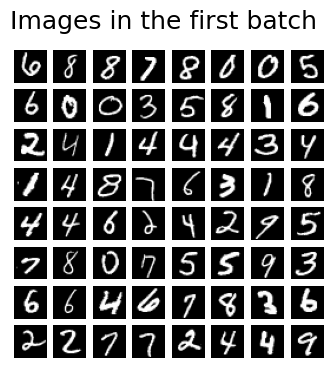

In [5]:
def show_first_batch(loader):
    for batch_feats,batch_labels in loader:
        print(batch_labels)
        print(batch_feats.shape)
        show_images(batch_feats, "Images in the first batch")
        break
show_first_batch(loader)

### Your conditional DDPM implementation should go here
This includes functionality for adding noise to the image.

In [87]:
class Forward_pass:
    def __init__(self) -> None:
        #number of steps
        self.N = N
        self.beta_min = BMIN
        self.beta_max = BMAX
        self._betas, self._alphas, self._alpha_bars = (0, 0 ,0)
        self.get_coefs()
    
    ##linear steps     
    def get_coefs(self):
        """Get the coefficients for the noise schedule.
        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]: 
                betas, alphas, alpha_bars
        """        
        self._betas = torch.linspace(self.beta_min, self.beta_max, self.N)
        self._alphas = 1 - self._betas
        self._alpha_bars = torch.cumprod(self._alphas, dim=0)

    #return the coef for initializing the denoising model
    def ret_coefs(self) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:

        return (self._betas,self._alphas,self._alpha_bars) 
   
    def _q_mean(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> torch.FloatTensor:
        # mean of the distribution q(z_t | z_0)
        sqrt_alpha_bars = torch.sqrt(self._alpha_bars[t.tolist()])
        return sqrt_alpha_bars.view(-1,1,1,1) * z

    def _q_std(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> torch.FloatTensor:
        # std of the distribution q(z_t | z_0)
        std = torch.sqrt(1.0 - self._alpha_bars[t.tolist()])
        return std.view(-1,1,1,1)

    def q_sample(
        self,
        z: torch.FloatTensor,
        t: torch.LongTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        # Sample from q(z_t | z_0)

        mean = self._q_mean(z, t)
        std = self._q_std(z, t)
        epsilon = torch.randn_like(z)
        z_t = epsilon * std + mean

        return z_t, epsilon
    
    ##for training, sample random n timesteps for each input, return the repeated features, times-steps sampled and the episilons
    def q_sample_random(
        self,
        z: torch.FloatTensor,
        lables: torch.FloatTensor,
        n_timesteps = 5,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,   torch.IntTensor, torch.IntTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = list(torch.randint(0, self.N-1, (n_timesteps,)))
        print(times)
        times_list = [torch.Tensor([i]).repeat(z.shape[0]).to(torch.int64) for i in times ]
        times_repeated = torch.cat(times_list)
        lables_repeated = lables.repeat(n_timesteps)
        z_repeated = z.repeat(n_timesteps,1,1,1) #shape=(batch_size*5, 1, 28, 28)
        mean = self._q_mean(z_repeated, times_repeated)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z_repeated, times_repeated)
        epsilon = torch.randn_like(z_repeated)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times_repeated, lables_repeated
    
    
    ##for training, sample randomly one timestep for each img, return the repeated features, times-steps sampled and the episilons
    def q_sample_random2(
        self,
        z: torch.FloatTensor,
        lables: torch.FloatTensor,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor,  torch.IntTensor, torch.IntTensor]:
        # Sample from q(z_t | z_0)
        #we use the same times steps for all the samples in this batch for simplicity
        times = torch.randint(0, self.N-1, (z.shape[0],))
        mean = self._q_mean(z, times)  #shape=(batch_size, 1, 28, 28)
        std = self._q_std(z, times)
        epsilon = torch.randn_like(z)
        
        z_out = epsilon * std + mean

        return z_out, epsilon, times, lables

### The implementation of the neural network used to estimate the noise should go here
The network should make use of both time and context embedding.

Any functions/methods used for time and context embeddings should also go here.

In [57]:
## we use only simple residual-CNN as the backbone models (copied from https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py)
class ResidualConvBlock(torch.nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.GELU(),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class ConditionedBackbone(torch.nn.Module):
    def __init__(self, in_channels = 1, hidden_channels = 64, image_size = 28, n_classes=11, n_layers=4, num_timesteps=N) -> None:
        super(ConditionedBackbone, self).__init__()

        self.in_channels = in_channels
        self.n_feat = hidden_channels
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.image_size = image_size
        self.num_timesteps = num_timesteps

        self.conv_layers = torch.nn.Sequential()
        self.conv_layers.add_module("conv_init", ResidualConvBlock(self.in_channels, hidden_channels, is_res=True))
        for i in range(n_layers-2):
            self.conv_layers.add_module(f'conv{i}',ResidualConvBlock(hidden_channels, hidden_channels, is_res=True))
        self.conv_layers.add_module("conv_final", ResidualConvBlock(hidden_channels, self.in_channels, is_res=True))

        #for simplicity we only add trainable embeddings to the input feature map(Xt), the size is the image size
        self.time_emb = torch.nn.Linear(self.num_timesteps, self.image_size**2) 
        self.lable_emb = torch.nn.Linear(n_classes, self.image_size**2)
        
    def forward(self, x, lables, t) -> float:
        # x is (noisy) image batch (from the Forward_pass for training and from the N(0,1) for sampling),  (batch_size, channel(1), 28, 28)
        # diff_noise are the corresponding noise in the forward pass, 
        #labels are the numbers from 0-10, 10 represents the unconditioned sample, t is the timestep usually from 0-999, 

        # using one hot embedding for the lable and time and a learned transformation
        lables = torch.nn.functional.one_hot(lables, num_classes=self.n_classes).type(torch.float)
        time_steps = torch.nn.functional.one_hot(t, num_classes=N).type(torch.float)
        #prepare the conditioned input 
        lable_embedding  = self.lable_emb(lables).view(-1, 1, self.image_size, self.image_size)
        time_embdding = self.time_emb(time_steps).view(-1, 1, self.image_size, self.image_size) 
        
        #feed into the network and predict the noise
        e_pred = self.conv_layers(x + lable_embedding + time_embdding)
        
        return e_pred
    
class Reverse_pass(torch.nn.Module):
    def __init__(self, model, alphas, alpha_bars, betas, num_classes = 11 ) -> None:
        super().__init__()
        self.model = model
        #self.model.to(device)
        self.N = N
        self.num_classes = num_classes
        ##for computing the samples
        self.alphas = alphas
        self.sqrt_1_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        ##we use the simpler version of sigma for the reverse pass
        self.sigmas = torch.sqrt(betas) 
        self.guidence_w = guidence_w
        
        #loss
        self.mse = torch.nn.MSELoss()
        
    def sample(self, n_samples = 3, image_size = 28): 
        ## sample "n" samples for each number “0-9” (including the unditional label "10") using 'Classifier-Free Diffusion Guidance'
        with torch.no_grad():
            #sample noised images and arrange labels
            batch_size = n_samples*self.num_classes
            #x_batch = torch.randn(batch_size, 1, image_size, image_size).to(device)
            x_batch = torch.randn(batch_size, 1, image_size, image_size)
            ##labels = [0,0,0,1,1,1,2,2,2....]  
            labels = [ torch.tensor([i]).repeat(n_samples) for i in range(self.num_classes)]
            #labels = torch.cat(labels).to(device)
            labels = torch.cat(labels)
            # unconditioned labels for interpolation (label = 10)
            labels_uncon = torch.full_like(labels, self.num_classes-1)
            labels = torch.cat((labels, labels_uncon))
            last_batch = x_batch
            for i in range(self.N, 0, -1):
                print(f'sampling timestep {i}\n')
                #current_t = torch.tensor([i]).to(device)
                current_t = torch.tensor([i-1])  #i-1 for one-hot encoding
                t_batch = current_t.repeat(batch_size) #(batch_size)

                # duplicate the current img for unconditioned sampling
                x_doubled = last_batch.repeat(2,1,1,1) #(2*batch_size, channel, img_size, img_size)
                t_doubled = t_batch.repeat(2) #(2*batch_size)

                # predict the diffusion noise, and interpolate
                diff_noise = self.model(x_doubled, labels, t_doubled)
                diff_con = diff_noise[:batch_size]
                diff_uncon = diff_noise[batch_size:]
                diff_noise_final = (1+self.guidence_w)*diff_con - self.guidence_w*diff_uncon
                # predict x_t-1
                #observation_noise = torch.randn(batch_size, 1, image_size, image_size).to(device) if i > 1 else 0
                observation_noise = torch.randn(batch_size, 1, image_size, image_size) if i > 1 else 0
                x_predict = (1/torch.sqrt(self.alphas[i-1])) * (last_batch - diff_noise_final * (1 - self.alphas[i-1]) / self.sqrt_1_minus_alpha_bars[i-1]) + self.sigmas[i-1] * observation_noise
                
                last_batch = x_predict
            return last_batch
    
    def compute_loss(self, batch_input, batch_noise, batch_time, batch_lables):
        #a batch of diffused input (by the forward process), with its difuusion noise,  timesteps and labels as input
        # return the loss of this batch for training the model
        
        predicted_noise = self.model(batch_input, batch_lables, batch_time)
        return self.mse(batch_noise, predicted_noise)

### Show that you can generate images before the model is trained
This should demonstrate that the backwards pass works. The generated images are expected to be noise.

sampling timestep 300

sampling timestep 299

sampling timestep 298

sampling timestep 297

sampling timestep 296

sampling timestep 295

sampling timestep 294

sampling timestep 293

sampling timestep 292

sampling timestep 291

sampling timestep 290

sampling timestep 289

sampling timestep 288

sampling timestep 287

sampling timestep 286

sampling timestep 285

sampling timestep 284

sampling timestep 283

sampling timestep 282

sampling timestep 281

sampling timestep 280

sampling timestep 279

sampling timestep 278

sampling timestep 277

sampling timestep 276

sampling timestep 275

sampling timestep 274

sampling timestep 273

sampling timestep 272

sampling timestep 271

sampling timestep 270

sampling timestep 269

sampling timestep 268

sampling timestep 267

sampling timestep 266

sampling timestep 265

sampling timestep 264

sampling timestep 263

sampling timestep 262

sampling timestep 261

sampling timestep 260

sampling timestep 259

sampling timestep 258

sampling ti

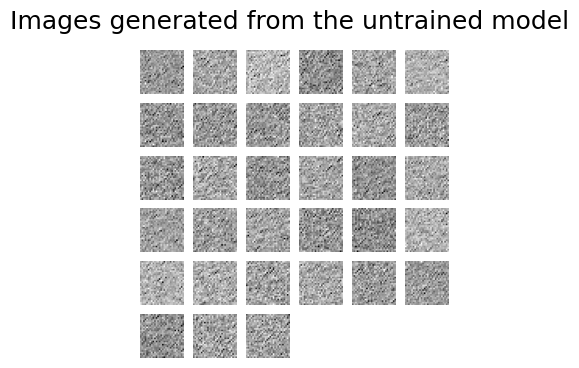

In [88]:
model = ConditionedBackbone()
forward = Forward_pass()
betas,alphas,alpha_bars = forward.ret_coefs()
reverse = Reverse_pass(model, alphas, alpha_bars, betas)
return_batch = reverse.sample()
show_images(return_batch, "Images generated from the untrained model")


### Implement training loop
Train the model here. There should be some indication of how long the model took to train, both total and per epoch. For good results you will want to train the model for several epochs, but with a good implementation you should expect to see something that looks like digits after only a single epoch.

In [93]:
def train_conditionedDDPM(n_epochs = 30, learning_rate = 1e-4):
    print(f"{sum(p.numel() for p in reverse.parameters() if p.requires_grad)} parameters to train")
    optimizer = torch.optim.Adam(reverse.parameters(), lr=learning_rate)
    for i in range(n_epochs):
        print(f"Training epoch: {i+1}")
        progress_loader = tqdm(loader)
        for batch_feats,batch_labels in progress_loader:
            optimizer.zero_grad()
            #sample with forward pass
            #z_out, epsilon_target, times, labels= forward.q_sample_random(batch_feats, batch_labels)
            z_out, epsilon_target, times, labels= forward.q_sample_random2(batch_feats, batch_labels)
            loss = reverse.compute_loss(z_out, epsilon_target, times, labels)
            loss.backward()
            optimizer.step()
            

### Train and visualize the model
We want to see several generated examples of each digit.

In [94]:
model = ConditionedBackbone()
forward = Forward_pass()
betas,alphas,alpha_bars = forward.ret_coefs()
reverse = Reverse_pass(model, alphas, alpha_bars, betas)
train_conditionedDDPM()

432031 parameters to train
Training epoch: 1


100%|██████████| 938/938 [01:10<00:00, 13.34it/s]


Training epoch: 2


100%|██████████| 938/938 [01:09<00:00, 13.49it/s]


Training epoch: 3


100%|██████████| 938/938 [01:09<00:00, 13.41it/s]


Training epoch: 4


100%|██████████| 938/938 [01:10<00:00, 13.27it/s]


Training epoch: 5


100%|██████████| 938/938 [01:10<00:00, 13.36it/s]


Training epoch: 6


100%|██████████| 938/938 [01:10<00:00, 13.32it/s]


Training epoch: 7


100%|██████████| 938/938 [01:10<00:00, 13.35it/s]


Training epoch: 8


100%|██████████| 938/938 [01:10<00:00, 13.35it/s]


Training epoch: 9


100%|██████████| 938/938 [01:10<00:00, 13.25it/s]


Training epoch: 10


100%|██████████| 938/938 [01:10<00:00, 13.27it/s]


Training epoch: 11


100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


Training epoch: 12


100%|██████████| 938/938 [01:11<00:00, 13.11it/s]


Training epoch: 13


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


Training epoch: 14


100%|██████████| 938/938 [01:10<00:00, 13.24it/s]


Training epoch: 15


100%|██████████| 938/938 [01:10<00:00, 13.24it/s]


Training epoch: 16


100%|██████████| 938/938 [01:10<00:00, 13.24it/s]


Training epoch: 17


100%|██████████| 938/938 [01:11<00:00, 13.14it/s]


Training epoch: 18


100%|██████████| 938/938 [01:11<00:00, 13.12it/s]


Training epoch: 19


100%|██████████| 938/938 [01:11<00:00, 13.11it/s]


Training epoch: 20


100%|██████████| 938/938 [01:11<00:00, 13.12it/s]


Training epoch: 21


100%|██████████| 938/938 [01:11<00:00, 13.13it/s]


Training epoch: 22


100%|██████████| 938/938 [01:10<00:00, 13.35it/s]


Training epoch: 23


100%|██████████| 938/938 [01:10<00:00, 13.32it/s]


Training epoch: 24


100%|██████████| 938/938 [01:10<00:00, 13.22it/s]


Training epoch: 25


100%|██████████| 938/938 [01:11<00:00, 13.05it/s]


Training epoch: 26


100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


Training epoch: 27


100%|██████████| 938/938 [01:10<00:00, 13.25it/s]


Training epoch: 28


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


Training epoch: 29


100%|██████████| 938/938 [01:11<00:00, 13.16it/s]


Training epoch: 30


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


sampling timestep 300

sampling timestep 299

sampling timestep 298

sampling timestep 297

sampling timestep 296

sampling timestep 295

sampling timestep 294

sampling timestep 293

sampling timestep 292

sampling timestep 291

sampling timestep 290

sampling timestep 289

sampling timestep 288

sampling timestep 287

sampling timestep 286

sampling timestep 285

sampling timestep 284

sampling timestep 283

sampling timestep 282

sampling timestep 281

sampling timestep 280

sampling timestep 279

sampling timestep 278

sampling timestep 277

sampling timestep 276

sampling timestep 275

sampling timestep 274

sampling timestep 273

sampling timestep 272

sampling timestep 271

sampling timestep 270

sampling timestep 269

sampling timestep 268

sampling timestep 267

sampling timestep 266

sampling timestep 265

sampling timestep 264

sampling timestep 263

sampling timestep 262

sampling timestep 261

sampling timestep 260

sampling timestep 259

sampling timestep 258

sampling ti

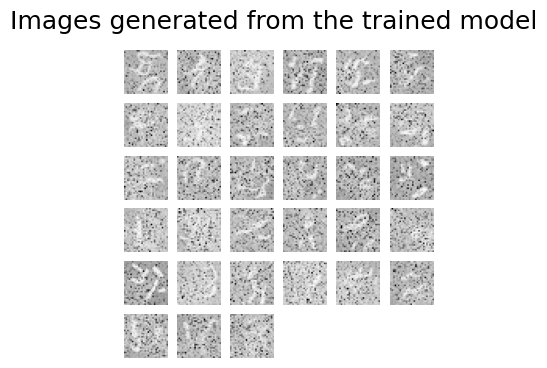

In [95]:
return_batch = reverse.sample()
show_images(return_batch, "Images generated from the trained model")